# Resolución numérica de la ecuación de Schrödinger

La ecuación de Schrödinger para una partícula en una dimensión es

$$
\begin{equation}
i \hbar \dfrac{\partial}{\partial t} \psi(x, t) = -\dfrac{\hbar^2}{2m} \dfrac{\partial^2}{\partial x^2}\psi(x,t) + V(x, t) \psi(x,t).
\end{equation}
$$


Vamos a restringir los potenciales a estudiar a aquellos para los cuales $V(a, t) = V(b, t) = \infty$, para dados $a$ y $b$ tales que $b-a = L > 0$. En esos casos, puede demostrarse que las soluciones satisfacen $\psi(a, t) = \psi(b, t) = 0$, lo cual representa nuestras condiciones de contorno.


## Adimnesionalización

Al igual que en el caso de la ecuación independiente del tiempo, adimensionalizamos las variables. Usamos la convención $\hbar = 1$ y definimos las variables $u = x/L$, $\tau = t/mL^2, $\tilde{V} = mL^2V$.

$$
\begin{equation}
i \dfrac{\partial  \psi}{\partial \tau} = -\dfrac{1}{2} \dfrac{\partial^2 \psi}{\partial u^2} + \tilde{V}(u, \tau) \psi(u, \tau).
\end{equation}
$$

## Métodos de resolución

### Primer método: diferencias finitas

Construimos una grilla discreta en posición y tiempo con espaciamiento $\Delta u$ y $\Delta \tau$ y definimos $\psi_j^m \equiv \psi(j\Delta x, m\Delta\tau)$ y $\tilde{V}_j^m \equiv \tilde{V}(j\Delta x, m\Delta\tau)$. Utilizando diferencias finitas a primer orden, podemos escribir

$$
\begin{equation}
i\frac{\psi_{j}^{m+1} - \psi_{j}^{m}}{\Delta \tau} = - \frac{1}{2}\frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{\Delta u^2} +\tilde{V}_j^m\psi_j^m.
\end{equation}
$$ 

Reordenando los términos, obtenemos

$$\psi_{j}^{m+1} = \psi_j^m + \frac{i}{2}\frac{\Delta \tau}{\Delta u^2}\left(\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}\right) - i \Delta \tau V_j^m\psi_j^m$$ 

### Segundo método: evolución de los autoestados

Este método consiste en resolver primero la ecuación (adimensionalizada) independiente del tiempo

$$
\begin{equation}
-\dfrac{1}{2} \dfrac{d^2\varphi}{du^2} + \tilde{V}(u) \varphi(u) = \lambda \varphi(u)
\end{equation}
$$

y luego aplicar los postulados para obtener la evolución temporal

$$
\begin{equation}
\psi(u,\tau) = \sum_{j=0}^\infty c_j \varphi_j(u) e^{-i \lambda_j t} \hspace{20mm} c_j = \int_{a}^{b} \psi(u, 0)\varphi_j^*(u) du.
\end{equation}
$$

## Aplicación de los métodos

Importamos las librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal
import seaborn as sns

sns.set_context("talk")

#%matplotlib ipympl

### Primer método

Definimos los parámetros y variables de interés

In [2]:
Nu = 301
Ntau = 100000
du = 1 / (Nu - 1)
dtau = 1e-7
u = np.linspace(0, 1, Nu)

**Observación:** Para que el método de diferencias finitas funcione de manera correcta, es necesario que el cociente $\Delta \tau / (\Delta u)^2$ sea pequeño. Veamos cuánto vale en nuesttro caso

In [3]:
dtau / du**2

0.008999999999999998

Para simplificar el análisis, vamos a definir un potencial independiente del tiempo

In [4]:
#V_tilde = 1000 * np.exp(-(u-0.25)**2/(2*0.05**2)) - 500*np.exp(-(u-0.6)**2/(2*0.05**2))
mu, sigma = 1/2, 1/20
V_tilde = -1e4*np.exp(-(u-mu)**2/(2*sigma**2))

Graficamos el potencial

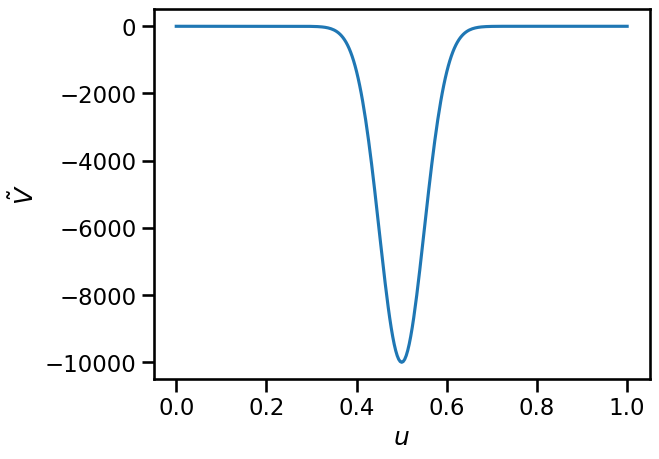

In [5]:
fig, ax = plt.subplots()
ax.plot(u, V_tilde)
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$\tilde{V}$")
plt.show()

Establecemos la condición inicial $\psi(u, 0)$

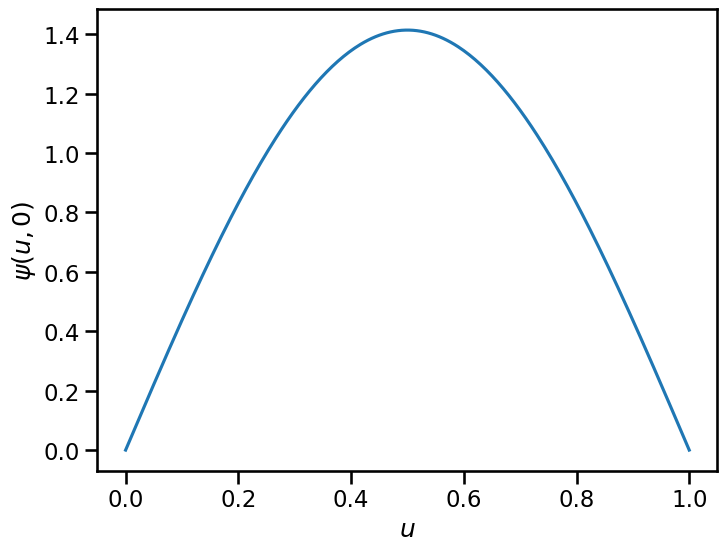

In [6]:
psi0 = np.sqrt(2)*np.sin(np.pi*u)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$\psi(u, 0)$")
ax.plot(u, psi0)
plt.show()

In [7]:
psi = np.zeros([Ntau,Nu], dtype="complex")
psi[0] = psi0

Aplicamos el algoritmo de diferencias finitas usando `numba`.

In [8]:
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Ntau-1):
        for i in range(1, Nu-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dtau/du**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dtau*V_tilde[i]*psi[t][i]

        normal = np.sum(np.abs(psi[t+1])**2)*du
        for i in range(1, Nu-1):
            psi[t+1][i] = psi[t+1][i]/normal

    return psi

In [9]:
psi_m1 = compute_psi(psi)

Observamos la función de onda a distintos tiempos

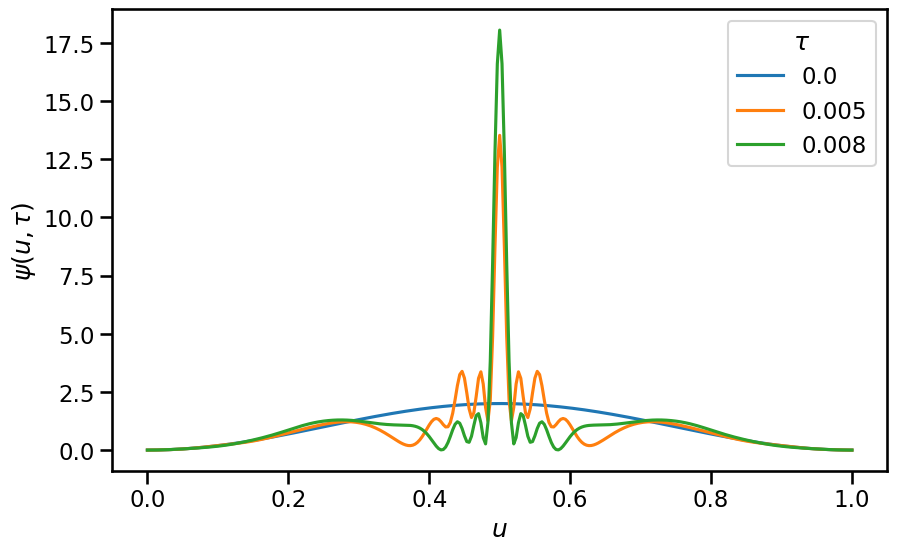

In [10]:
it_values = [0, 50000, 80000]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$\psi(u, \tau)$")

for i in it_values:
    ax.plot(u, np.absolute(psi_m1[i])**2, label=i*dtau)
ax.legend(title=r"$\tau$")
plt.show()

### Segundo método

In [11]:
d = 1/du**2 + V_tilde[1:-1]
e = -1/(2*du**2) * np.ones(len(d)-1)
w, v = eigh_tridiagonal(d, e)

In [12]:
E_js = w[0:70]
psi_js = np.pad(v.T[0:70], [(0, 0), (1, 1)], mode='constant')
cs = np.dot(psi_js, psi0)

def psi_m2(t):
    return psi_js.T@(cs*np.exp(-1j*E_js*t))

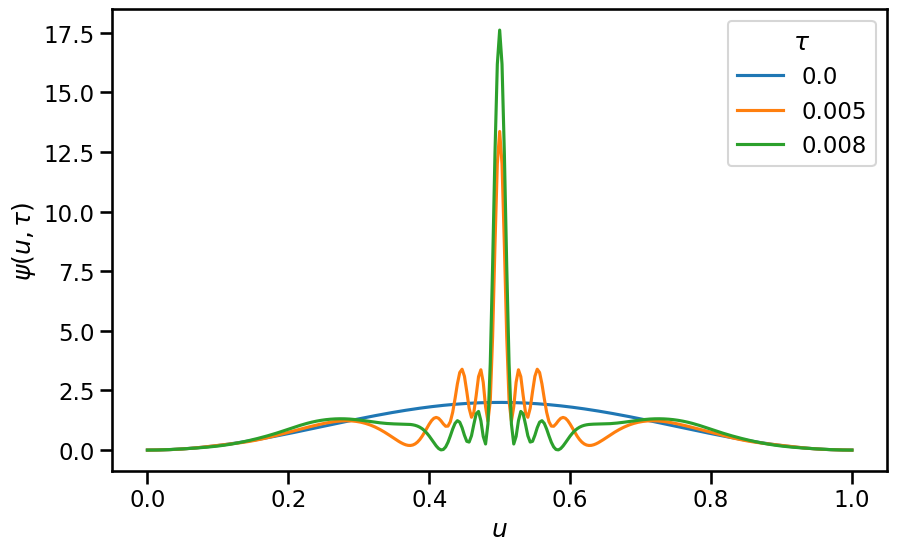

In [13]:
it_values = [0, 50000, 80000]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$\psi(u, \tau)$")

for i in it_values:
    ax.plot(u, np.absolute(psi_m2(i*dtau))**2, label=i*dtau)
ax.legend(title=r"$\tau$")
plt.show()

## Animación

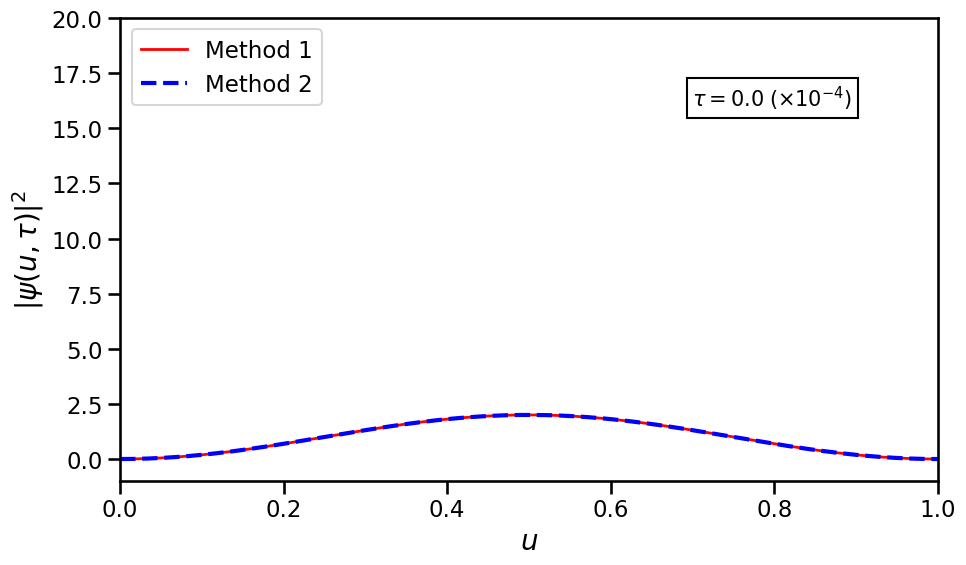

In [16]:
def animate(i):
    ln1.set_data(u, np.absolute(psi_m1[100*i])**2)
    ln2.set_data(u, np.absolute(psi_m2(100*i*dtau))**2)
    time_text.set_text(r'$\tau=$'+'{:.1f}'.format(100*i*dtau*1e4) + r"$\;(\times 10^{-4})$")

fig, ax = plt.subplots(1,1, figsize=(10,6))
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Method 1')
ln2, = plt.plot([], [], 'b--', lw=3, markersize=8, label='Method 2')
time_text = ax.text(0.7, 16, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 20)
ax.set_xlim(0,1)
ax.set_ylabel(r"$|\psi(u, \tau)|^2$", fontsize=20)
ax.set_xlabel(r"$u$", fontsize=20)
ax.legend(loc="upper left")
plt.tight_layout()

ani = animation.FuncAnimation(fig, animate, frames=1000, interval=100)
ani.save('pen.gif', writer='pillow', fps=50, dpi=100)

### Paquete Gaussiano

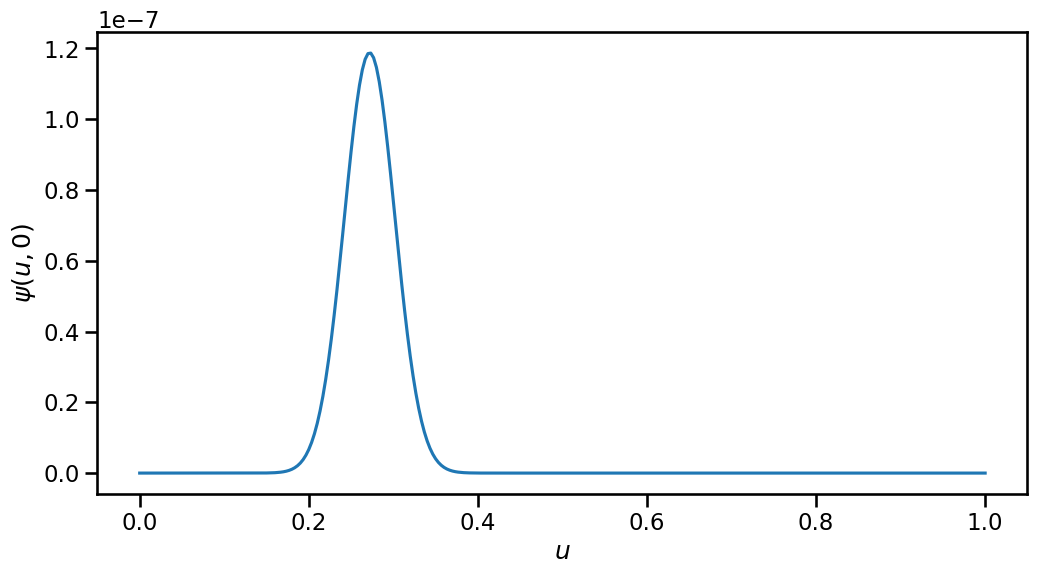

In [28]:

mu = 0.2
sigma = 0.03
k0 = 1e-3
psi0 = np.exp(-(u-mu)**2/(2*sigma**2)) * np.exp(i*k0*u)
psi0 = psi0 / (np.sum(np.abs(psi0)**2) * du)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$\psi(u, 0)$")
ax.plot(u, psi0)
plt.show()

In [29]:
psi = np.zeros([Ntau,Nu], dtype="complex")
psi[0] = psi0

In [30]:
psi_m1 = compute_psi(psi)

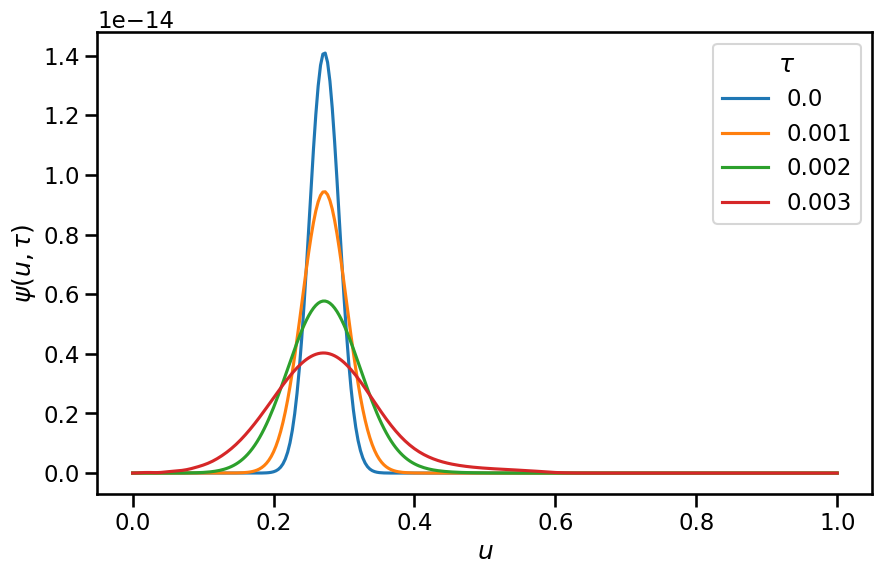

In [33]:
it_values = [0, 10000, 20000, 30000]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$\psi(u, \tau)$")

for i in it_values:
    ax.plot(u, np.absolute(psi_m1[i])**2, label=i*dtau)
ax.legend(title=r"$\tau$")
plt.show()